In [0]:
# Connect to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import libraries
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import random, math, sys
import pandas as pd

In [0]:
"""
Function Name:  discretize_gt()
Parameters: gt
Functionality: This function
               1) discetize the Ground Truth
returns: discrete valued gt

"""
def discretize_gt(gt):

	import warnings

	warnings.warn('can improve the way GT is discretized')

	return gt/255


"""
Function Name:  auc_judd()
Parameters: s_map,gt
Functionality: This function
               1) Calculate the AUC score between Ground Truth and the predicted
                  Saliency for different techniques, like Itti-koch, Deep Gaze, 
                  FCN etc.

"""

def auc_judd(s_map,gt):
	# ground truth is discrete, s_map is continous and normalized
  gt = np.ceil(discretize_gt(gt))
  gt = np.array(gt, dtype="int")
  # print(int(np.max(gt)))

	# thresholds are calculated from the salience map, only at places where fixations are present
  thresholds = []
  for i in range(0,gt.shape[0]):
    for k in range(0,gt.shape[1]):
      if gt[i][k]>0:
        thresholds.append(s_map[i][k])


  num_fixations = np.sum(gt)
	# num fixations is no. of salience map values at gt >0
  thresholds = sorted(set(thresholds))

	#fp_list = []
	#tp_list = []
  area = []
  area.append((0.0,0.0))

  for thresh in thresholds:

		# in the salience map, keep only those pixels with values above threshold
    temp = np.zeros(s_map.shape)
    temp[s_map>=thresh] = 1.0
    # print(np.max(gt))

    assert np.max(gt)==1, 'something is wrong with ground truth..not discretized properly max value > 1'
    assert np.max(s_map)==1, 'something is wrong with salience map..not normalized properly max value > 1'

    num_overlap = np.where(np.add(temp,gt)==2)[0].shape[0]
    tp = num_overlap/(num_fixations*1.0)

		# total number of pixels > threshold - number of pixels that overlap with gt / total number of non fixated pixels
		# this becomes nan when gt is full of fixations..this won't happen
    fp = (np.sum(temp) - num_overlap)/((np.shape(gt)[0] * np.shape(gt)[1]) - num_fixations)
    area.append((round(tp,4),round(fp,4)))
	

  area.append((1.0,1.0))

  area.sort(key = lambda x:x[0])
  tp_list =  [x[0] for x in area]
  fp_list =  [x[1] for x in area]
  return np.trapz(np.array(tp_list),np.array(fp_list))





In [0]:
# data directory for the ground truth saliency
dir_data = "/content/drive/My Drive/HCI_prep/Prediction_and_Analysis/Evaluation_Data/Ground_Truth_Eyemap/"
path_to_data = "/content/drive/My Drive/HCI_prep/Prediction_and_Analysis/"

# Path for Saliency Prediction using other different methods 

#FCN
FCN = path_to_data+"Evaluation_Data/FCN16/predicted_images/"

#Deep GazeII
Deep_GazeII = path_to_data+"Evaluation_Data/Deep_Gaze_II/Density_Prediction/"

#GDI
GDI = path_to_data+"Evaluation_Data/GDI/GDI_predictions/"

#Itti_Koch
Itti_Koch = path_to_data+"Evaluation_Data/Itti_koch/test_saliency_128/"

# Random Forest
Random_Forest = path_to_data+"Evaluation_Data/RT/RandomForestPrediction/"

# #SVM
SVM = path_to_data+"Evaluation_Data/SVM/SVM_Degree2_Prediction/"

#SALICON
SALICON = path_to_data+"Evaluation_Data/SALICON/"

# Create a dictionary using the above mentioned paths
dir_data_pred_dict= {"FCN":FCN,"Deep_GazeII":Deep_GazeII,"GDI":GDI,"Itti_Koch":Itti_Koch,"Random_Forest":Random_Forest,"SVM":SVM,"SALICON":SALICON}


In [0]:
"""
Function Name: return_image_size()
Functionalities: This function takes path of a predicted image and returns the 
                size of the image
Parameter:path
Returns: img.shape[0],img.shape[1]

"""
def return_image_size(path):
  img = cv2.imread(path,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img.shape[0],img.shape[1]


"""
Function Name: Groung_Image_Arr()
Functionalities: 1) BGR-GRAY conversion
                 2) Resizing to height*weight
                 3) values range from 0 to 255
Parameter:path, width, height,title
Returns: label
"""
def Groung_Image_Arr(path, width, height,title):
  #print(path)
  # print(title)
  img = cv2.imread(path,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (width, height))
  label = np.array(img, dtype=np.uint8) # values range from 0 to 255
  #print(label.max())
  return label


"""
Function Name: pred_img_Arr()
Functionalities: 1) BGR-GRAY conversion
                 2) Resizing to height*weight
                 3) values range from 0 to 255
Parameter:path, width, height,title
Returns: label
"""

def pred_img_Arr(path, width, height,title):
  img = cv2.imread(path,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (width, height))
  label = np.array(img, dtype=np.uint8) # values range from 0 to 255
  #print(label.max())
  return label


"""
Function Name: normalize_map()
Functionalities: normalises the saliency map
Parameter:s_map
Returns: norm_s_map
"""

def normalize_map(s_map):
	# normalize the salience map (as done in MIT code)
	norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
	return norm_s_map


In [0]:
dict_Judd = {}

# create nd array for evaluation
for dir_data_pred_name,dir_data_pred in dir_data_pred_dict.items():

  dict_AUC_Judd = {}
  
  list_AUC_Judd = []
 
  # print (dir_data_pred)
  print (dir_data_pred_name)

  pred_saliency_data = os.listdir(dir_data_pred)
  pred_saliency_data.sort()
  saliency_data = os.listdir(dir_data)
  saliency_data.sort()

  
  # Take the size of the predicted image for processing of the grund truth image 
  #(Because some models return 224*224, some models, like RF, Itti-Koch and 
  # SVM return 128*128 images)
  input_width, input_height = return_image_size(dir_data_pred+pred_saliency_data[0])
  
  # resize if predicted image size is more than 224*224
  if input_width>224:
    input_width, input_height = 224,224

  for im in saliency_data:
    # print(im)

    #call to Groung_Image_Arr
    gt = Groung_Image_Arr(dir_data+im, input_width, input_height,im)

    #call to pred_img_Arr   
    s_map = pred_img_Arr(dir_data_pred+im, input_width, input_height,im)

    #call to normalize 
    s_map_norm = normalize_map(s_map)

    # call to calculate AUC score
    auc_judd_score = auc_judd(s_map_norm,gt)
    
    dict_AUC_Judd.update({im:auc_judd_score})
    list_AUC_Judd.append(auc_judd_score)
    print (im + ' auc judd :', auc_judd_score)
   
  # take max, min and average of AUC score
  mx_judd = max(list_AUC_Judd)
  mn_judd = min(list_AUC_Judd)
  avg_judd = sum(list_AUC_Judd)/len(list_AUC_Judd)

 
  # Store all the data in a dictionary
  dic_res_judd = {}
  
  dic_res_judd["max"] = mx_judd
  dic_res_judd["min"] = mn_judd
  dic_res_judd["avg"] = avg_judd
  
  
  dict_Judd[dir_data_pred_name] = dic_res_judd
  print("#########################################################################")

  
print(dict_Judd)

# Save the score as csv file
df = pd.DataFrame(dict_Judd)
df.to_csv(path_to_data+"/Evaluation_Result/"+"AUC_Judd_"+"results.csv")




FCN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: can improve the way GT is discretized
  """


cell.png auc judd : 0.754206755
ebay_music.png auc judd : 0.74667582
flickr_cover.png auc judd : 0.890374235
flipboard-editor.png auc judd : 0.836806105
indiegogo.png auc judd : 0.787261
microsoft.png auc judd : 0.7219229199999999
pinterest_about.png auc judd : 0.8441521799999999
science.png auc judd : 0.7656154000000001
zaobao.png auc judd : 0.8491388500000001
#########################################################################
Deep_GazeII
cell.png auc judd : 0.698139745
ebay_music.png auc judd : 0.7803552599999999
flickr_cover.png auc judd : 0.9231908000000002
flipboard-editor.png auc judd : 0.8935840449999999
indiegogo.png auc judd : 0.7575119199999999
microsoft.png auc judd : 0.853034375
pinterest_about.png auc judd : 0.8948370999999999
science.png auc judd : 0.7387555949999999
zaobao.png auc judd : 0.750672755
#########################################################################
GDI
cell.png auc judd : 0.666315145
ebay_music.png auc judd : 0.8563822849999999
flickr_cover.

Plot the score in a Bar plot

                    max       min       avg
FCN            0.890374  0.721923  0.799573
Deep_GazeII    0.923191  0.698140  0.810009
GDI            0.889966  0.666315  0.820829
Itti_Koch      0.772334  0.527947  0.643620
Random_Forest  0.757444  0.587963  0.660234
SVM            0.719650  0.516200  0.593278
SALICON        0.903556  0.739423  0.841652


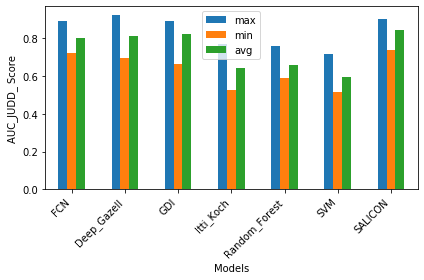

In [0]:

df_new=df.T
print(df_new)

#df= df.reset_index()
import seaborn as sns

fig = df_new.plot(kind='bar')
#plt.margins(0.02)
plt.ylabel("AUC_JUDD_"+" Score")
plt.xlabel('Models')
fig.set_xticklabels(df_new.T.columns, rotation = 45, ha="right")
plt.tight_layout()

#plt.grid(True)

plt.savefig(path_to_data+"Evaluation_Result/"+"AUC_JUDD_"+".png")
